In [ ]:
%pip install -U langgraph langsmith langchain_anthropic langchain_openai langchain_community langchain_experimental

In [2]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

In [3]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


# llm = ChatAnthropic(model="claude-3-5-sonnet-latest")
llm = ChatOpenAI(model="gpt-4o")


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

In [4]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


research_agent = create_react_agent(
    llm, tools=[tavily_tool], prompt="You are a researcher. DO NOT do any math."
)


def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: State) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
graph = builder.compile()

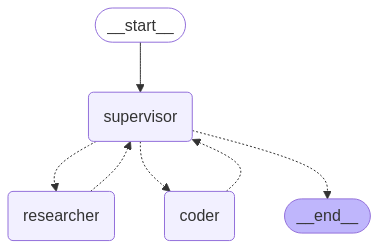

In [5]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'coder'}})
----


Python REPL can execute arbitrary code. Use with caution.


(('coder:e4d42bb2-9a69-ea77-0ada-5a72814a18e9',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_CQDMEg2m8NEKTgtiW0tfPdBi', 'function': {'arguments': '{"code":"import math\\nmath.sqrt(42)"}', 'name': 'python_repl_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 96, 'total_tokens': 120, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_898ac29719', 'id': 'chatcmpl-BJTxdlLU0OCAJSMH8qSa8OP5J7Sqh', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0f144ef1-d3d2-45ef-8e33-6b1b64c4dac0-0', tool_calls=[{'name': 'python_repl_tool', 'args': {'code': 'import math\nmath.sqrt(42)'}, 'id': 'call_CQDMEg2m8NEKTgtiW0tfPdBi', 'type': 'tool_call'}], usage_metadat

In [7]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Find the latest GDP of New York and California, then calculate the average",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:c58c16d4-e950-eb6d-52fd-9faa2e7f063a',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_a2osz8a3xnAyIwirOC79BT62', 'function': {'arguments': '{"query": "latest GDP of New York 2024"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_aNc27j29KzjVrHxuREelsCbd', 'function': {'arguments': '{"query": "latest GDP of California 2024"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 104, 'total_tokens': 170, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_6dd05565ef', 'id': 'chatcmpl-BJTxfXHMRl10Cm1zW13a4vTEJ9WYj', 'finish_reason': 'tool_

### TEST

In [3]:
from typing import Literal
from langchain_openai import ChatOpenAI
from langgraph.types import Command
from langgraph.graph import StateGraph, MessagesState, START, END

model = ChatOpenAI()

def supervisor(state: MessagesState) -> Command[Literal["agent_1", "agent_2", END]]:
    # you can pass relevant parts of the state to the LLM (e.g., state["messages"])
    # to determine which agent to call next. a common pattern is to call the model
    # with a structured output (e.g. force it to return an output with a "next_agent" field)
    response = model.invoke(...)
    # route to one of the agents or exit based on the supervisor's decision
    # if the supervisor returns "__end__", the graph will finish execution
    return Command(goto=response["next_agent"])

def agent_1(state: MessagesState) -> Command[Literal["supervisor"]]:
    # you can pass relevant parts of the state to the LLM (e.g., state["messages"])
    # and add any additional logic (different models, custom prompts, structured output, etc.)
    response = model.invoke(...)
    return Command(
        goto="supervisor",
        update={"messages": [response]},
    )

def agent_2(state: MessagesState) -> Command[Literal["supervisor"]]:
    response = model.invoke(...)
    return Command(
        goto="supervisor",
        update={"messages": [response]},
    )

builder = StateGraph(MessagesState)
builder.add_node(supervisor)
builder.add_node(agent_1)
builder.add_node(agent_2)

builder.add_edge(START, "supervisor")

supervisor = builder.compile()